In [2]:
import numpy as np
from numba import vectorize, complex64, boolean, jit
from PIL import Image
import tensorflow as tf
import os, sys, itertools, time

import keras
import itertools

from keras.layers         import Dense
from keras.models         import Model
from keras.models         import Sequential
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

import _pickle as cPickle
working_dir = "models/"
file_write_loc = "models/results.txt"

C:\Users\Varsha\AppData\Local\Continuum\Anaconda2\envs\ipykernel_py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
@jit
def f(z, c):   #iterating function
    return z * z + c
@jit
def does_diverge(z, c, iters):  #checks if a given pixel diverges
#     iters = 3
    for _ in range(iters):
        z = f(z, c)
        if abs(z) > 2: # Diverges
            return 1
    return 0

# generates X values across an image of size "size"
def generate_julia_xvals(size):
    x = np.linspace(-2, 2, size * 3)
    y = np.linspace(-1, 1, size * 2)
    X = np.array(list(itertools.product(y, x)))[:, (1, 0)]
    return X
   
# generates X and y values for julia set
def generate_julia_set(size, c=False, iterations=50):
    X = generate_julia_xvals(size)
    if not c:
        output = np.array([does_diverge(complex(*sample), complex(*sample), iterations) for sample in X])
    else:
        output = np.array([does_diverge(complex(*sample), c, iterations) for sample in X])
    return X, output.reshape((size * 2, size * 3)) #image format

# generates X and y values and appends the imaginary value to the X matrix
def generate_test_X_vals(a, b, size):
    show_vals = generate_julia_xvals(size)
    avals = np.array([[a]*show_vals.shape[0]]).T
    bvals = np.array([[b]*show_vals.shape[0]]).T
    test_X = np.hstack((np.hstack((show_vals, avals)), bvals))
    return test_X

# appends the imaginary value to the X matrix
def append_c(X, a, b):
    avals = np.array([[a]*X.shape[0]]).T
    bvals = np.array([[b]*X.shape[0]]).T
    new_X = np.hstack((np.hstack((X, avals)), bvals))
    return new_X

# creates and plots a fractal using the imaginary value
@jit
def plot_fractal_from_c(c, size=128):
    iterations = 50
    start = time.time()
    X, res = generate_julia_set(size, c=c, iterations=iterations)
    plt.figure()
    ax = plt.imshow(res, cmap = 'gray')
    ax = plt.gca()
    ax.grid(linewidth=0)
    plt.show()
    end = time.time()
    return append_c(X, c.real, c.imag), res

# plots a fractal using the y values
def plot_fractal_from_pred(pred, size):
    pred = np.reshape(pred, (size*2, size*3))
    plt.figure()
    ax = plt.imshow(pred, cmap = 'gray')
    ax = plt.gca()
    ax.grid(linewidth=0)
    plt.show()
    end = time.time()

# plots a fractal after rounding the y values to 1 or 0
def plot_fractal_from_pred_classified(pred, size):
#     plt.figure(figsize=(6,4))
    img = np.reshape(pred, (size*2, size*3))
    img[img < .5] = 0
    img[img >= .5] = 1

#     plt.subplot(6,4,i)
    plt.imshow(img, cmap="gray")
    plt.show()

In [19]:
from sklearn.ensemble import RandomForestRegressor

# creates the X matrix
@jit
def assemble_feature(X, D):
    xs = []
    for d0 in range(D + 1):
        for d1 in range(D - d0 + 1):
            xs.append((X[:, 0]**d0)*(X[:, 1]**d1))
    return np.column_stack(xs)

# shuffles two lists together    
def shuffle_in_unison(A, b):
    assert len(A) == len(b)
    shuffled_A = np.empty(A.shape, dtype=A.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(A))
    for old_index, new_index in enumerate(permutation):
        shuffled_A[new_index] = A[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_A, shuffled_b
  
# calculates accuracy of a prediction after rounding the values
def accuracy(b, pred):
    b[b < .5] = 0
    b[b >= .5] = 1
    pred[pred < .5] = 0
    pred[pred >= .5] = 1
    b = np.reshape(b, (1,-1))
    pred = np.reshape(pred, (1,-1))
    return np.average(np.abs(b-pred))

# trains random forest and reports the out of bag score
def train_random_forest(train_X, train_y, n_estimate):
    rf = RandomForestRegressor(n_estimators = n_estimate, oob_score = True, verbose = 1)
    rf.fit(train_X, train_y)
    gen_error = rf.oob_score_
    return rf, gen_error

# tests random forest model and returns the prediction and accuracy
def test_random_forest(test_X, test_y, rf):
    pred = rf.predict(test_X)
    test_err = accuracy(test_y, pred)
    return pred, test_err

# makes a fractal with an imaginary value and image size and tests a random forest model on it
def make_and_test(a, b, size, rf):
    print("Make and test: ",a,b,size,rf)
    test_X, test_y = plot_fractal_from_c(a+b*1j, size)
    print(test_X.shape, test_y.shape)
    pred = rf.predict(test_X)
    print(pred.shape)
    plot_fractal_from_pred(pred, size)
    plot_fractal_from_pred_classified(pred, size)
    test_err = accuracy(test_y, pred)
    print("Accuracy:",1-test_err)
    return pred, test_err


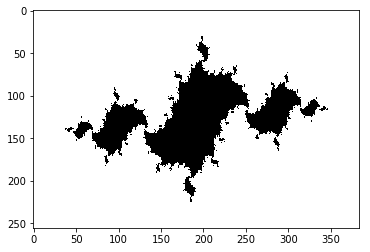

In [20]:
# example of plotting a fractal
a = -1
b = 0.2
X_test, Y_test = plot_fractal_from_c(a+b*1j, 128)

0.3 -0.5


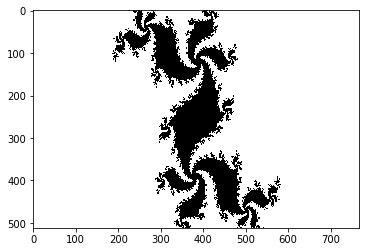

In [14]:
# another example of plotting a fractal
a = 0.3
b = -0.5
X_test, Y_test = plot_fractal_from_c(a+b*1j, 256)

Test Image: c: [[1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
 ...
 [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]]


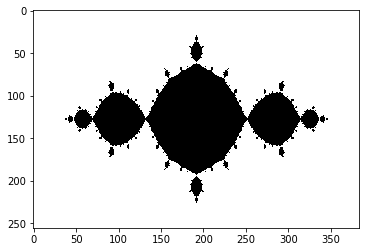

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished
C:\Users\Varsha\AppData\Local\Continuum\Anaconda2\envs\ipykernel_py3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


n_est: 5 percent_train: 10 train_err: 0.004103615423864715 test_err: 0.015370015054941177


[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed:    0.5s finished


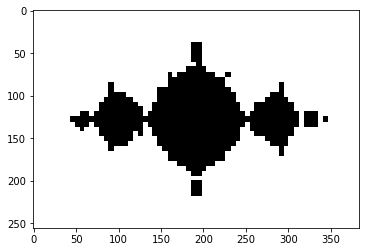

In [188]:
size = 128
X = load_array('task2data/X.npy')
X_abvalues = load_array('task2data/X_abvalues.npy')
Y = load_array('task2data/Y.npy')

print("Test Image:","c:",a+b*1j)
plot_image(Y_test)

# 98304
# 6585120
num_estimators = [5, 25, 125]
percent_trains = [10]
rfs = {}

# Simple training loop: more explanation in next code cell
# Training and testing over number of estimators and percentage of training data as hyperparameters
for n_estimate in num_estimators:
    for percent_train in percent_trains:
        
        num_train = percent_train * X.shape[0] // 100
        X_copy = np.copy(X)
        Y_copy = np.copy(Y)
        shuffle_in_unison(X_copy, Y_copy)
        X_copy = X_copy[0:num_train]
        Y_copy = Y_copy[0:num_train]
        
        start = time.time()
        rf_temp, train_err = train_random_forest(X_copy, Y_copy, n_estimate)
        end = time.time()
        runtime = end - start
        
        rfs[(n_estimate, num_train)] = rf_temp
        test_pred, test_err = test_random_forest(X_test, Y_test, rf)
        
        print("n_est:",n_estimate,"percent_train:",percent_train,"train_err:",train_err,"test_err:",test_err)
        plot_image(test_pred)

        


In [15]:
X = load_array('task2data/X.npy')
X_abvalues = load_array('task2data/X_abvalues.npy')
Y = load_array('task2data/Y.npy')

Test Image: c: (-1+0.2j)


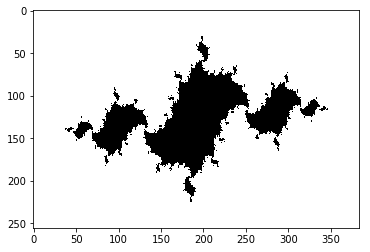

X_copy_size (658512, 4)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   19.5s finished
C:\Users\Varsha\AppData\Local\Continuum\Anaconda2\envs\ipykernel_py3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.5s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


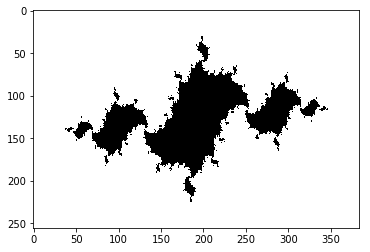

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


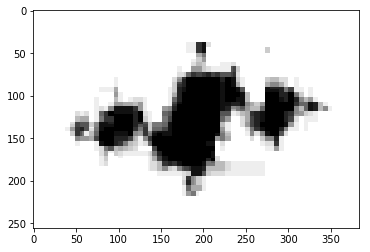

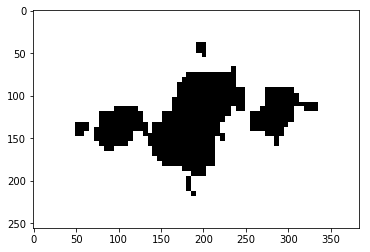

Accuracy: 0.96295166015625
n_est: 15, percent_train: 10, percent_test: 20, gen_acc: 0.8690544724459759, test_acc: 0.9720240481570571, image_test_acc: 0.96295166015625, runtime: 20.58073925971985
X_copy_size (2634048, 4)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.6min finished
C:\Users\Varsha\AppData\Local\Continuum\Anaconda2\envs\ipykernel_py3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.0s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


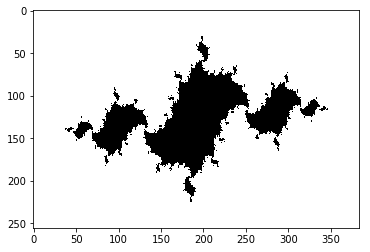

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


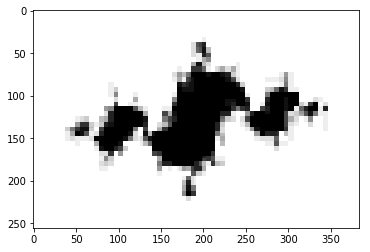

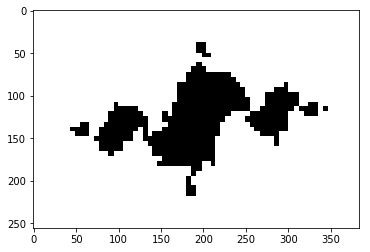

Accuracy: 0.9717203776041666
n_est: 15, percent_train: 40, percent_test: 20, gen_acc: 0.9017201235540924, test_acc: 0.9792205760866924, image_test_acc: 0.9717203776041666, runtime: 100.56848740577698
X_copy_size (3951072, 4)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.6min finished
C:\Users\Varsha\AppData\Local\Continuum\Anaconda2\envs\ipykernel_py3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.6s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


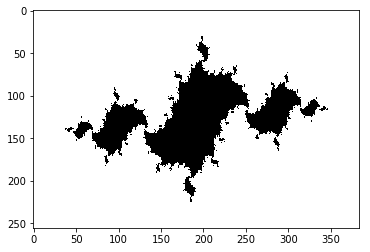

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


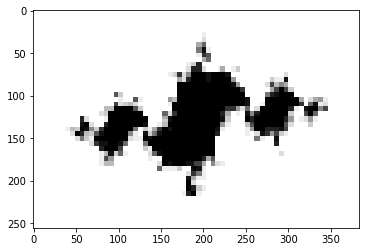

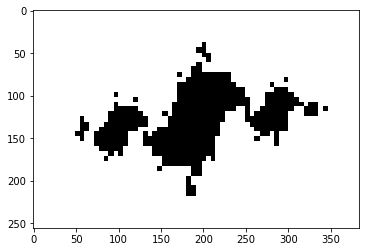

Accuracy: 0.9730631510416666
n_est: 15, percent_train: 60, percent_test: 20, gen_acc: 0.9112775531277924, test_acc: 0.9810937386106859, image_test_acc: 0.9730631510416666, runtime: 160.49398016929626
X_copy_size (658512, 4)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    9.0s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


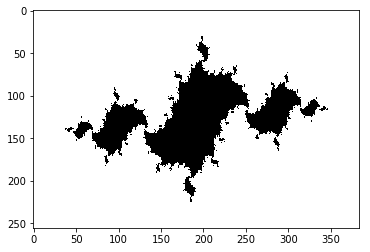

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


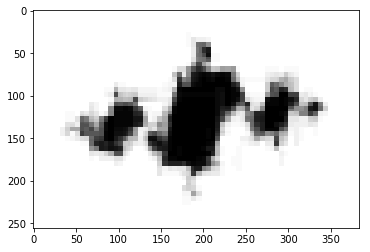

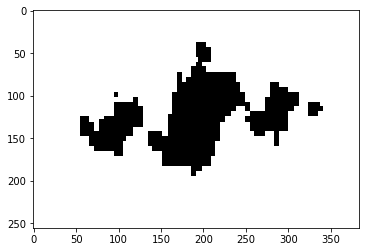

Accuracy: 0.964996337890625
n_est: 50, percent_train: 10, percent_test: 20, gen_acc: 0.891822013819261, test_acc: 0.9733505236047331, image_test_acc: 0.964996337890625, runtime: 74.1209967136383
X_copy_size (2634048, 4)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.9s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


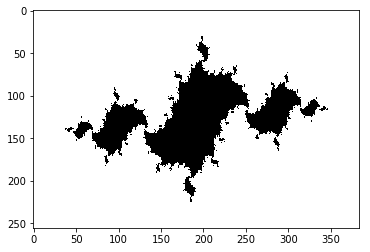

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


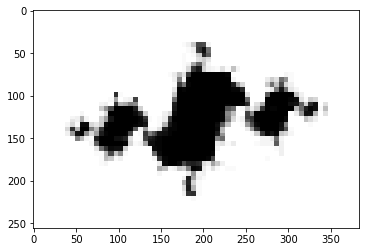

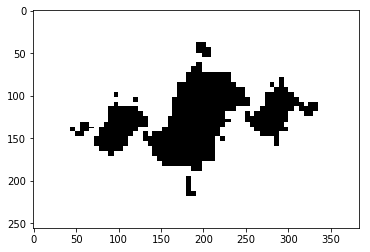

Accuracy: 0.9724629720052084
n_est: 50, percent_train: 40, percent_test: 20, gen_acc: 0.9186470964235821, test_acc: 0.9796776672255023, image_test_acc: 0.9724629720052084, runtime: 341.70121812820435
X_copy_size (3951072, 4)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.6min finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   12.0s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


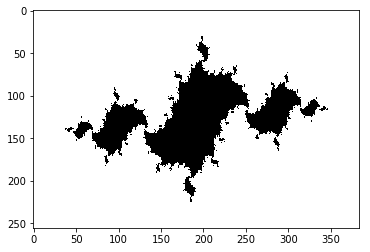

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


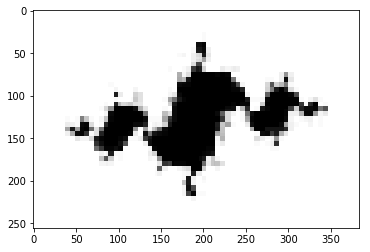

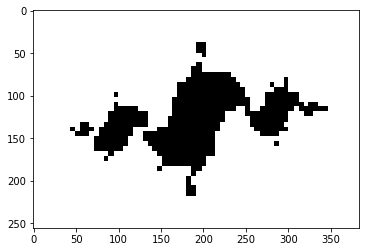

Accuracy: 0.9732157389322916
n_est: 50, percent_train: 60, percent_test: 20, gen_acc: 0.9262197645292027, test_acc: 0.9819122506499502, image_test_acc: 0.9732157389322916, runtime: 539.9202973842621
X_copy_size (658512, 4)


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   23.1s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


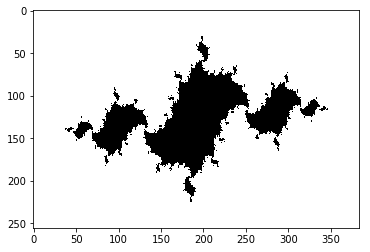

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished


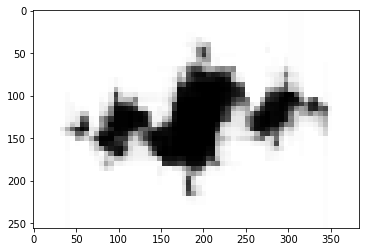

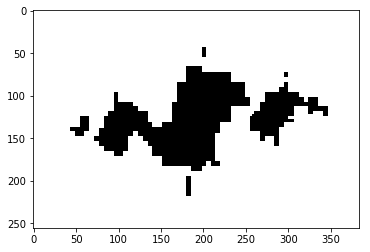

Accuracy: 0.9652099609375
n_est: 125, percent_train: 10, percent_test: 20, gen_acc: 0.8963925604135147, test_acc: 0.9734887139490245, image_test_acc: 0.9652099609375, runtime: 202.09404349327087
X_copy_size (2634048, 4)


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 13.7min finished
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   29.1s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


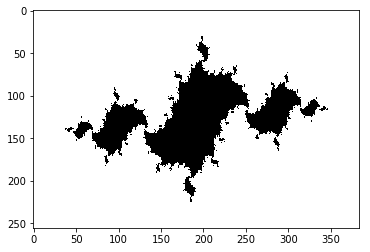

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.6s finished


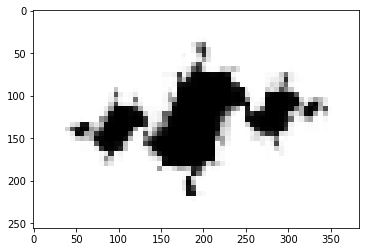

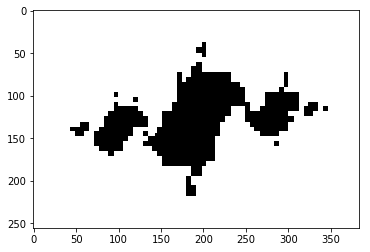

Accuracy: 0.972412109375
n_est: 125, percent_train: 40, percent_test: 20, gen_acc: 0.9211372296995006, test_acc: 0.9802980051996015, image_test_acc: 0.972412109375, runtime: 864.740261554718
X_copy_size (3951072, 4)


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 21.6min finished
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   27.8s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


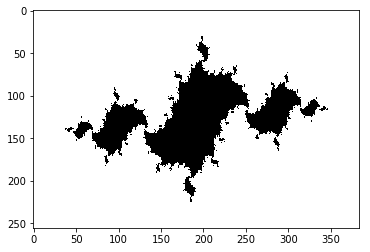

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.5s finished


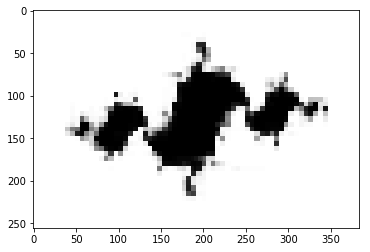

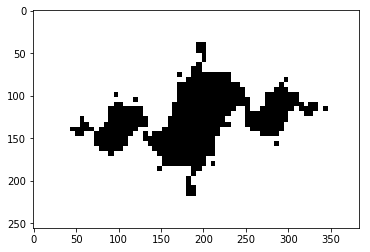

Accuracy: 0.9737141927083334
n_est: 125, percent_train: 60, percent_test: 20, gen_acc: 0.9285360519348619, test_acc: 0.9820474038438176, image_test_acc: 0.9737141927083334, runtime: 1355.727635383606
X_copy_size (658512, 4)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.7min finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   34.4s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


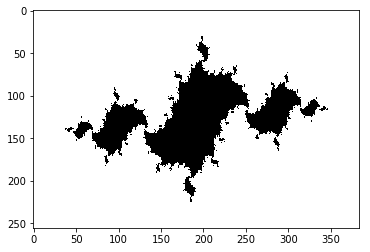

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


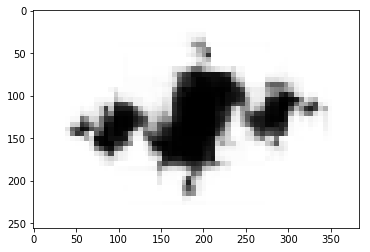

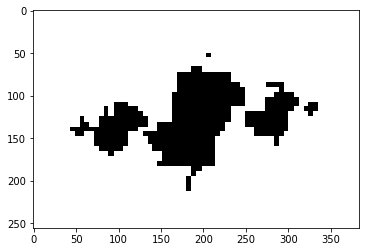

Accuracy: 0.9662272135416666
n_est: 200, percent_train: 10, percent_test: 20, gen_acc: 0.8971118411796128, test_acc: 0.9739321379109265, image_test_acc: 0.9662272135416666, runtime: 293.8229351043701
X_copy_size (2634048, 4)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 20.7min finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   40.5s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


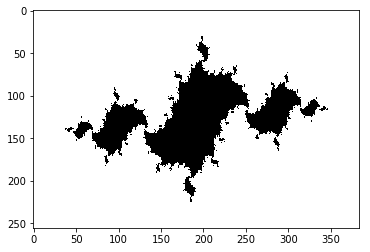

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


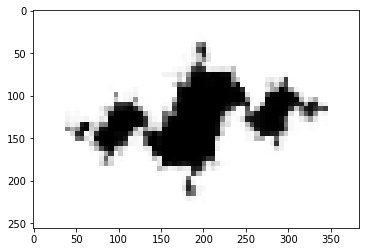

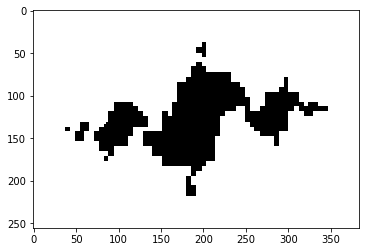

Accuracy: 0.9725850423177084
n_est: 200, percent_train: 40, percent_test: 20, gen_acc: 0.922676242421206, test_acc: 0.9804331583934689, image_test_acc: 0.9725850423177084, runtime: 1300.83633518219
X_copy_size (3951072, 4)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 31.9min finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   43.1s finished


Make and test:  -1.0 0.2 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


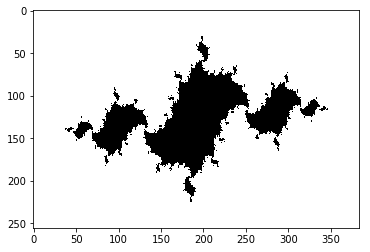

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


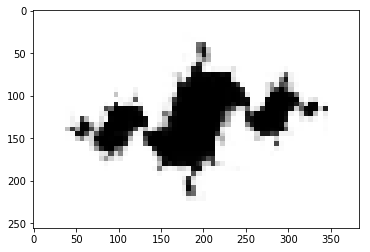

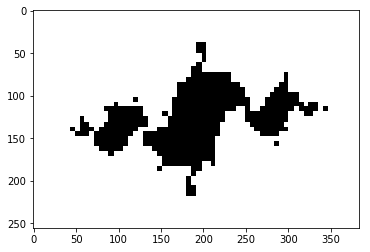

Accuracy: 0.9732666015625
n_est: 200, percent_train: 60, percent_test: 20, gen_acc: 0.9291069353271061, test_acc: 0.981947177879826, image_test_acc: 0.9732666015625, runtime: 2002.0062172412872


In [22]:
test_a = -1.0
test_b = 0.2
size = 128

print("Test Image:","c:",test_a+test_b*1j)
plot_fractal_from_c(test_a+test_b*1j,size)

# 98304 = size of one image subsection
# 6585120 = size of total data
num_estimators = [15, 50, 125, 200]
percent_trains = [10, 40, 60]
percent_test = 20

rfs = {}
test_large_errs = []

# Training and testing over number of estimators and percentage of training data as hyperparameters
for n_estimate in num_estimators:
    for percent_train in percent_trains:
        
        # define number of training and testing data
        num_train = percent_train * X.shape[0] // 100
        num_test = (100-percent_test) * X.shape[0] // 100
        
        # preprocess data
        X_copy = np.copy(X)
        Y_copy = np.copy(Y)
        X_copy, Y_copy = shuffle_in_unison(X_copy, Y_copy)
        X_large_test = X_copy[num_test:]
        Y_large_test = Y_copy[num_test:]
        X_copy = X_copy[0:num_train]
        Y_copy = Y_copy[0:num_train]
        print("X_copy_size", X_copy.shape)
        
        # train model, measure start and end time
        start = time.time()
        rf_temp, gen_acc = train_random_forest(X_copy, Y_copy, n_estimate)
        end = time.time()
        runtime = end - start
        rfs[(n_estimate, num_train)] = rf_temp
        
        # write model to file
        with open(to_file_name(working_dir,n_estimate,percent_train), 'wb') as f:
            cPickle.dump(rf_temp, f)
        
        # test model
        test_large_pred, test_large_err = test_random_forest(X_large_test, Y_large_test, rf_temp)
        img_test_pred, img_test_err = make_and_test(test_a,test_b,size,rf_temp)
        
        # string to print results
        result_string = "n_est: "+str(n_estimate)+", percent_train: "+str(percent_train)+", percent_test: "+str(percent_test)
        result_string+= ", gen_acc: "+str(gen_acc)+", test_acc: "+str(1-test_large_err)
        result_string+= ", image_test_acc: "+str(1-img_test_err)+", runtime: "+str(runtime)
        
        # write results to results.txt
        file = open(file_write_loc,'a')
        file.write(result_string+"\n")
        file.close()
        
        print(result_string)

Make and test:  0.3 -0.5 128 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


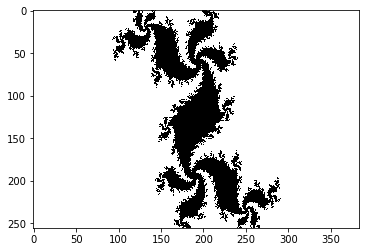

(98304, 4) (256, 384)
(98304,)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


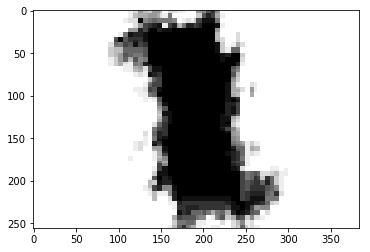

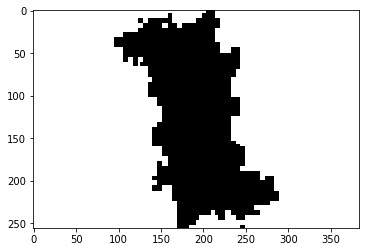

Accuracy: 0.8778279622395834
(array([1., 1., 1., ..., 1., 1., 1.]), 0.12217203776041667)
Make and test:  0.3 -0.5 256 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)


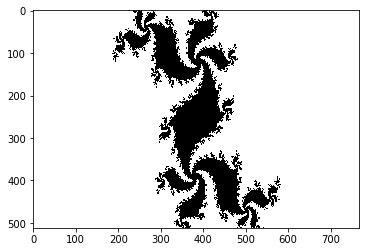

(393216, 4) (512, 768)
(393216,)


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished


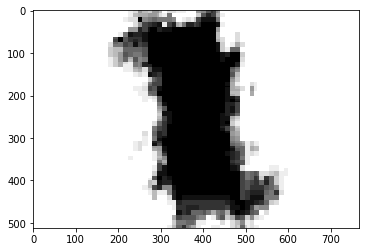

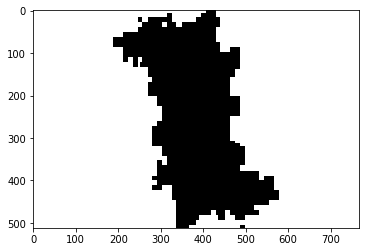

Accuracy: 0.8771209716796875
(array([1., 1., 1., ..., 1., 1., 1.]), 0.1228790283203125)


In [125]:
## Make and test the model on a very difficult fractal
print(make_and_test(0.3,-0.5,128,list(rfs.values())[0]))
print(make_and_test(0.3,-0.5,256,list(rfs.values())[0]))